In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from scipy.sparse import csr_matrix
from sklearn.feature_extraction import DictVectorizer
from sklearn.utils import resample
!pip install fastFM
from fastFM import sgd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

!pip install -U deepctr-torch
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
from deepctr_torch.models import *

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/filtered-train/filtered_train.csv
/kaggle/input/avazu-ctr-prediction/sampleSubmission.gz
/kaggle/input/avazu-ctr-prediction/train.gz
/kaggle/input/avazu-ctr-prediction/test.gz


# Part 1: ETL

In [2]:
# import gzip

# # Path to the gzip file
# file_path = '/kaggle/input/avazu-ctr-prediction/train.gz'

# # Open the gzip file and read it as a CSV
# with gzip.open(file_path, 'rt') as f:
#     df = pd.read_csv(f).sample(frac=0.5, random_state=42)

In [21]:
file_path = '/kaggle/input/filtered-train/filtered_train.csv'

df = pd.read_csv(file_path)

In [10]:
# Display the first few rows of the dataframe
df.head()

,Unnamed: 0,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,128037,1.107451e+19,0,14102101,1005,1,e151e245,7e091613,f028772b,ecad2386,...,1,0,20352,320,50,2333,0,39,-1,157
1,491755,1.240012e+19,0,14102103,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,1,0,15701,320,50,1722,0,35,100084,79
2,470924,1.059801e+19,0,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,...,1,0,17614,320,50,1993,2,1063,-1,33
3,791624,1.844219e+18,0,14102104,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,...,1,0,16208,320,50,1800,3,167,100075,23
4,491263,1.236016e+19,1,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,...,1,0,17614,320,50,1993,2,1063,-1,33


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        404290 non-null  int64  
 1   id                404290 non-null  float64
 2   click             404290 non-null  int64  
 3   hour              404290 non-null  int64  
 4   C1                404290 non-null  int64  
 5   banner_pos        404290 non-null  int64  
 6   site_id           404290 non-null  object 
 7   site_domain       404290 non-null  object 
 8   site_category     404290 non-null  object 
 9   app_id            404290 non-null  object 
 10  app_domain        404290 non-null  object 
 11  app_category      404290 non-null  object 
 12  device_id         404290 non-null  object 
 13  device_ip         404290 non-null  object 
 14  device_model      404290 non-null  object 
 15  device_type       404290 non-null  int64  
 16  device_conn_type  40

In [ ]:
# # Check each column for NaN values
# nan_columns = df.isnull().any()

# # Display columns with NaN values
# columns_with_nan = nan_columns[nan_columns].index.tolist()
# print(f"Columns with NaN values: {columns_with_nan}")

# # Display a summary of NaN values
# nan_summary = df.isnull().sum()
# print(nan_summary)

# Part 2: EDA

## Banner Position

In [12]:
# Group by banner_pos and click, then unstack to create a DataFrame suitable for plotting
banner_temp = df[['banner_pos', 'click']].groupby(['banner_pos', 'click']).size().unstack(fill_value=0)

# Rename columns
banner_temp.columns = ['No Click', 'Click']

# Create an interactive bar plot
fig = px.bar(banner_temp, x=banner_temp.index, y=banner_temp.columns, title='Banner Positions vs Clicks',
             labels={'value': 'Number'}, barmode='stack')

# Update layout
fig.update_layout(xaxis_title='Banner Position', yaxis_title='Number of Impressions',
                  legend_title='Click Status', xaxis={'categoryorder': 'total ascending'})

# Show the plot
fig.show()

## CTR by banner_pos

In [13]:
# Calculate total impressions for each banner position
total_impressions = df.groupby('banner_pos').size()

# Calculate total clicks for each banner position
total_clicks = df[df['click'] == 1].groupby('banner_pos').size()

# Calculate CTR for each banner position
ctr = (total_clicks / total_impressions) * 100  # Multiply by 100 to convert to percentage

# Create a DataFrame for plotting
ctr_df = pd.DataFrame({'Banner Position': ctr.index, 'CTR (%)': ctr.values})

# Create an interactive bar plot
fig = px.bar(ctr_df, x='Banner Position', y='CTR (%)', title='Click-Through Rate (CTR) for Each Banner Position',
             text='CTR (%)')

# Update layout to improve readability
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(xaxis_title='Banner Position', yaxis_title='CTR (%)')

# Show the plot
fig.show()

## Device Type

In [14]:
# Group by device_type and click, then unstack to create a DataFrame suitable for plotting
device_temp = df[['device_type', 'click']].groupby(['device_type', 'click']).size().unstack(fill_value=0)

# Rename columns
device_temp.columns = ['No Click', 'Click']

# Create an interactive bar plot
fig = px.bar(device_temp, x=device_temp.index, y=device_temp.columns, title='Device Types vs Clicks',
             labels={'value': 'Number'}, barmode='stack')

# Update layout
fig.update_layout(xaxis_title='Device Type', yaxis_title='Number of Impressions',
                  legend_title='Click Status', xaxis={'categoryorder': 'total ascending'})

# Show the plot
fig.show()

## CTR by device_type

In [15]:
# Calculate total impressions for each banner position
total_impressions = df.groupby('device_type').size()

# Calculate total clicks for each banner position
total_clicks = df[df['click'] == 1].groupby('device_type').size()

# Calculate CTR for each banner position
ctr = (total_clicks / total_impressions) * 100  # Multiply by 100 to convert to percentage

# Create a DataFrame for plotting
ctr_df = pd.DataFrame({'Device Type': ctr.index, 'CTR (%)': ctr.values})

# Create an interactive bar plot
fig = px.line(ctr_df, x='Device Type', y='CTR (%)', title='Click-Through Rate (CTR) for Each Device Type',
             text='CTR (%)')

# Update layout to improve readability
fig.update_traces(texttemplate='%{text:.2f}%', textposition='top right')
fig.update_layout(xaxis_title='Device Type', yaxis_title='CTR (%)')

# Show the plot
fig.show()

## Site category

In [16]:
# Group by device_type and click, then unstack to create a DataFrame suitable for plotting
device_temp = df[['site_category', 'click']].groupby(['site_category', 'click']).size().unstack(fill_value=0)

# Rename columns
device_temp.columns = ['No Click', 'Click']

# Create an interactive bar plot
fig = px.bar(device_temp, x=device_temp.index, y=device_temp.columns, title='Site Category vs Clicks',
             labels={'value': 'Number'}, barmode='stack')

# Update layout
fig.update_layout(xaxis_title='Site Category', yaxis_title='Number of Impressions',
                  legend_title='Click Status', xaxis={'categoryorder': 'total ascending'})

# Show the plot
fig.show()

## CTR by site_category

In [17]:
# Calculate total impressions for each site category
total_impressions = df.groupby('site_category').size()

# Calculate total clicks for each site category
total_clicks = df[df['click'] == 1].groupby('site_category').size()

# Calculate CTR for each site category
ctr = (total_clicks / total_impressions) * 100  # Multiply by 100 to convert to percentage

# Create a DataFrame for plotting
ctr_df = pd.DataFrame({'Site Category': ctr.index, 'CTR (%)': ctr.values})

# Add categories with CTR=0 to the DataFrame
categories_with_zero_ctr = df['site_category'].unique()
categories_with_nonzero_ctr = ctr_df[ctr_df['CTR (%)'] > 0]['Site Category'].unique()
categories_with_zero_ctr = set(categories_with_zero_ctr) - set(categories_with_nonzero_ctr)
zero_ctr_df = pd.DataFrame({'Site Category': list(categories_with_zero_ctr), 'CTR (%)': 0})
ctr_df = pd.concat([ctr_df, zero_ctr_df], ignore_index=True)

# Sort DataFrame by CTR in descending order
ctr_df = ctr_df.sort_values(by='CTR (%)', ascending=False)

# Create an interactive scatter plot for markers
fig = px.scatter(ctr_df, x='Site Category', y='CTR (%)', title='Click-Through Rate (CTR) for Each Site Category',
                 labels={'CTR (%)': 'CTR (%)'})

# Update layout to improve readability
fig.update_layout(xaxis_title='Site Category', yaxis_title='CTR (%)')

# Add line plot separately
fig.add_trace(px.line(ctr_df, x='Site Category', y='CTR (%)')['data'][0])

# Show the plot
fig.show()

## Hour of day

In [23]:
df['time'] = pd.to_datetime(df['hour'], format='%y%m%d%H')

# Extract hour from the datetime column
df['hour'] = df['time'].dt.hour

# Group by device_type and click, then unstack to create a DataFrame suitable for plotting
hour_temp = df[['hour', 'click']].groupby(['hour', 'click']).size().unstack(fill_value=0)

# Rename columns
hour_temp.columns = ['No Click', 'Click']

# Create an interactive bar plot
fig = px.bar(hour_temp, x=hour_temp.index, y=hour_temp.columns, title='Hour vs Clicks',
             labels={'value': 'Number'}, barmode='stack')

# Update layout
fig.update_layout(xaxis_title='Hour', yaxis_title='Number of Impressions',
                  legend_title='Click Status', xaxis={'categoryorder': 'total ascending'})

# Show the plot
fig.show()

## CTR by hour of day

In [19]:
# Calculate total impressions for each banner position
total_impressions = df.groupby('hour').size()

# Calculate total clicks for each banner position
total_clicks = df[df['click'] == 1].groupby('hour').size()

# Calculate CTR for each banner position
ctr = (total_clicks / total_impressions) * 100  # Multiply by 100 to convert to percentage

# Create a DataFrame for plotting
ctr_df = pd.DataFrame({'Hour': ctr.index, 'CTR (%)': ctr.values})

# Create an interactive bar plot
fig = px.line(ctr_df, x='Hour', y='CTR (%)', title='Click-Through Rate (CTR) for hour of the day',
             text='CTR (%)')

# Update layout to improve readability
fig.update_traces(texttemplate='%{text:.2f}%', textposition='top center')
fig.update_layout(xaxis_title='Hour', yaxis_title='CTR (%)')

# Show the plot
fig.show()

# Part 3: Feature Engineering

In [24]:
df['hour'] = df['time'].dt.strftime('%y%m%d%H')
df['hr'] = df['hour'].str[6:]

In [25]:
df.head(5)

,Unnamed: 0,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,...,C14,C15,C16,C17,C18,C19,C20,C21,time,hr
0,128037,1.107451e+19,0,14102101,1005,1,e151e245,7e091613,f028772b,ecad2386,...,20352,320,50,2333,0,39,-1,157,2014-10-21 01:00:00,01
1,491755,1.240012e+19,0,14102103,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,15701,320,50,1722,0,35,100084,79,2014-10-21 03:00:00,03
2,470924,1.059801e+19,0,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,...,17614,320,50,1993,2,1063,-1,33,2014-10-21 03:00:00,03
3,791624,1.844219e+18,0,14102104,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,...,16208,320,50,1800,3,167,100075,23,2014-10-21 04:00:00,04
4,491263,1.236016e+19,1,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,...,17614,320,50,1993,2,1063,-1,33,2014-10-21 03:00:00,03


In [26]:
df = df.drop(columns=['time', 'hour'])

In [27]:
df.nunique()

Unnamed: 0          402586
id                  402586
click                    2
C1                       7
banner_pos               7
site_id               2225
site_domain           2188
site_category           22
app_id                2241
app_domain             143
app_category            27
device_id            64742
device_ip           261706
device_model          4380
device_type              4
device_conn_type         4
C14                   2088
C15                      8
C16                      9
C17                    411
C18                      4
C19                     65
C20                    161
C21                     60
hr                      24
dtype: int64

In [28]:
df = df.drop(columns=(['device_ip','device_id','id', 'Unnamed: 0']))

In [29]:
df.head()

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hr
0,0,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,88fe1d5d,...,0,20352,320,50,2333,0,39,-1,157,01
1,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,3db9fde9,...,0,15701,320,50,1722,0,35,100084,79,03
2,0,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,c144e605,...,0,17614,320,50,1993,2,1063,-1,33,03
3,0,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,0eb711ec,...,0,16208,320,50,1800,3,167,100075,23,04
4,1,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,3bd9e8e7,...,0,17614,320,50,1993,2,1063,-1,33,03


# Part 4: Modeling

Note: I will choose auc-roc as the metric, which is the most commonly used in CTR prediction. Advantages:

- Balancing Sensitivity and Specificity
- Robust to Class Imbalance
- Threshold Agnostic
- Interpretability

## Gradient boost

In [30]:
df1 = df.copy()

In [31]:
# Get column types
column_types = df1.dtypes

# Identify string and integer columns
str_cols = column_types[column_types == 'object'].index.tolist()
int_cols = column_types[column_types == 'int'].index.tolist()

# Count distinct values in string and integer columns
str_cols_count = [(col, df1[col].nunique()) for col in str_cols]
int_cols_count = [(col, df1[col].nunique()) for col in int_cols]

from sklearn.preprocessing import LabelEncoder
# All of the columns (string or integer) are categorical columns except for the [click] column

# Define categorical columns with a maximum number of bins
max_bins = 70
categorical = [col for col, count in str_cols_count if count <= max_bins]
categorical += [col for col, count in int_cols_count if count <= max_bins]

cols_to_keep = categorical  

# Preserve only the specified columns
df1 = df1[cols_to_keep]

categorical.remove('click')

In [32]:
# Apply LabelEncoder to all categorical columns
label_encoders = {col: LabelEncoder() for col in categorical}
for col, le in label_encoders.items():
    df1[col] = le.fit_transform(df1[col])

# Assemble features into a single vector
features = [f"{col}" for col in categorical]
X = df1[features]
y = LabelEncoder().fit_transform(df1['click'])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train GradientBoostingClassifier model
gbt = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbt.fit(X_train, y_train)

# Execute predictions
y_pred = gbt.predict_proba(X_test)[:, 1]

# Evaluate the model using roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc}")

# Extract and display feature importances
importances = gbt.feature_importances_
feature_importances = sorted(zip(importances, features), key=lambda x: x[1], reverse=True)
feature_importances_df1 = pd.DataFrame(feature_importances, columns=["weight", "feature"])
print(feature_importances_df1)

# Create a temporary view for predictions
predictions_df1 = pd.DataFrame({'true_label': y_test, 'predicted_proba': y_pred})
print(predictions_df1)

ROC-AUC: 0.6967065510245247
      weight           feature
0   0.154938     site_category
1   0.016175                hr
2   0.019752       device_type
3   0.031280  device_conn_type
4   0.018731        banner_pos
5   0.117869      app_category
6   0.227901               C21
7   0.096145               C19
8   0.069801               C18
9   0.233320               C16
10  0.001644               C15
11  0.012443                C1
       true_label  predicted_proba
0               0         0.100851
1               0         0.112376
2               0         0.112899
3               0         0.173095
4               0         0.170324
...           ...              ...
80853           0         0.110152
80854           0         0.172855
80855           1         0.216844
80856           1         0.513086
80857           0         0.163442

[80858 rows x 2 columns]


## Factorization machine

Above methods assume different features are independent. But sometimes we should utilize feature-pair information.

Factorization Machines are a general model to deal with sparse and high dimensional features. Reference: https://arxiv.org/pdf/1505.00641

Factorization Machines takes inspiration from matrix factorization, and models the feature interaction using latent factors. Every feature $f_{i}$ has a corresponding latent factor $\textbf{v}_{i}$, and two features' interactions are modelled as $⟨\textbf{v}_{i},\textbf{v}_{j}⟩$, where ⟨⋅,⋅⟩ refers to the dot product of the two feature vector. If we assume its of size $k$ (this is a hyperparameter that we can tune, e.g. 'rank' parameter determines the dimensionality of these latent factor spaces.).

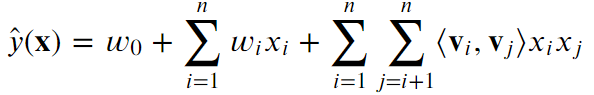

In [33]:
df_2 = df.copy()

In [34]:
# Separate majority and minority classes
df_2_majority = df_2[df_2.click == 0]
df_2_minority = df_2[df_2.click == 1]

# Downsample majority class
df_2_majority_downsampled = resample(df_2_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_2_minority), # match minority class count
                                   random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_2_balanced = pd.concat([df_2_minority, df_2_majority_downsampled])


# Separate features and target
X = df_2_balanced.drop(columns=['click'])

y = df_2_balanced['click'].apply(lambda x: 1 if x == 1 else -1)  # Convert 0 to -1 for fastFM

# Convert all columns to object type if they are not originally of that type
for col in X.columns:
    if X[col].dtype != 'object':
        X[col] = X[col].astype('object')
        
# Perform one-hot encoding
df_2_encoded = pd.get_dummies(X)

# Concatenate one-hot encoded columns to the original DataFrame
X.drop(columns=X.columns, inplace=True)
X[df_2_encoded.columns] = df_2_encoded

# Convert DataFrame to sparse matrix
X_sparse = csr_matrix(X.values)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size=0.2, random_state=42)

# Train the Factorization Machine model
# https://ibayer.github.io/fastFM/api.html#module-fastFM.sgd
fm = sgd.FMClassification(n_iter=10000, init_stdev=0.1, l2_reg=0.1, rank=2, step_size=0.01)
fm.fit(X_train, y_train)

# Predict CTR
y_pred_proba = fm.predict_proba(X_test)

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC:", roc_auc)

ROC AUC: 0.6912983211137491


Fine tune the model.

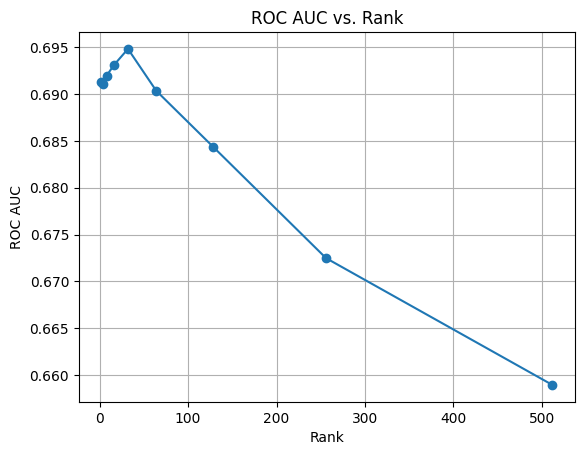

In [35]:
# Define the range of rank values to try
rank_values = [2, 4, 8, 16, 32, 64, 128, 256, 512]

# Initialize lists to store rank values and corresponding ROC AUC scores
roc_auc_scores = []

# Loop over each rank value
for rank in rank_values:
    # Train the Factorization Machine model with the current rank value
    fm = sgd.FMClassification(n_iter=10000, init_stdev=0.1, l2_reg=0.1, rank=rank, step_size=0.01)
    fm.fit(X_train, y_train)
    
    # Predict CTR
    y_pred_proba = fm.predict_proba(X_test)
    
    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store the rank value and corresponding ROC AUC score
    roc_auc_scores.append(roc_auc)

# Plot ROC AUC scores against rank values
plt.plot(rank_values, roc_auc_scores, marker='o')
plt.xlabel('Rank')
plt.ylabel('ROC AUC')
plt.title('ROC AUC vs. Rank')
plt.grid(True)
plt.show()

The best score is between 0.669 ~ 0.670.

## Wide and Deep

Some general guides about choosing wide and deep features: **wide features** - Categorical features with a limited number of unique values, numerical features, and interactions between features (e.g., feature crosses); **deep features** - High-cardinality categorical features, text data, and other features that can benefit from being transformed into dense representations.

In [7]:
df_3 = df.copy()

In [97]:
df_3.dtypes

click                int64
C1                   int64
banner_pos           int64
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_model        object
device_type          int64
device_conn_type     int64
C14                  int64
C15                  int64
C16                  int64
C17                  int64
C18                  int64
C19                  int64
C20                  int64
C21                  int64
hr                  object
dtype: object

In [8]:
# Define the function to map hour to time range
def assign_time_range(hour):
    if 0 <= int(hour) < 6:
        return 0
    elif 6 <= int(hour) < 12:
        return 1
    elif 12 <= int(hour) < 18:
        return 2
    elif 18 <= int(hour) < 24:
        return 3
    else:
        return 'Invalid hour'

# Apply the function to create a new column for time range
df_3['time_range'] = df_3['hr'].apply(assign_time_range)

### For wide component, use low-cardinality features (may include cross-features), For deep component, use sparse categorical features

In [9]:
# Feature engineering for Wide&Deep model
df_3['tr-app_category'] = df_3['time_range'].astype(str) + df_3['app_category']
df_3['tr-site_category'] = df_3['time_range'].astype(str) + df_3['site_category']
df_3['tr-device_type'] = df_3['time_range'].astype(str) + df_3['device_type'].astype(str)
df_3['banner_pos-device_type'] = df_3['banner_pos'].astype(str) + df_3['device_type'].astype(str)
df_3['device_type-app_category'] = df_3['device_type'].astype(str) + df_3['app_category']
df_3['device_type-site_category'] = df_3['device_type'].astype(str) + df_3['site_category']

In [10]:
df_3.drop(columns='hr', inplace=True)

In [11]:
obj_features = list(df_3.select_dtypes(['object']).columns)
int_features = list(df_3.select_dtypes(['int64']).columns)
int_features.remove('click')

for feat in obj_features:
    lbe = LabelEncoder()
    df_3[feat] = lbe.fit_transform(df_3[feat])

In [102]:
df_3.nunique()

click                           2
C1                              7
banner_pos                      7
site_id                      2225
site_domain                  2188
site_category                  22
app_id                       2241
app_domain                    143
app_category                   27
device_model                 4380
device_type                     4
device_conn_type                4
C14                          2088
C15                             8
C16                             9
C17                           411
C18                             4
C19                            65
C20                           161
C21                            60
time_range                      4
tr-app_category                88
tr-site_category               77
tr-device_type                 16
banner_pos-device_type         12
device_type-app_category       48
device_type-site_category      26
dtype: int64

In [12]:
CTR = df_3
# Do one-hot encoding for shallow features
shallow_features = CTR.loc[:, CTR.nunique() <= 100].columns.tolist()
shallow_features.remove('click')

for feat in shallow_features:
  CTR_temp = pd.get_dummies(CTR[feat], prefix=[feat])
  CTR = CTR.drop(feat, axis=1)
  CTR = pd.concat([CTR, CTR_temp], axis=1)

In [13]:
# generate input data for model
train, test = train_test_split(CTR, test_size=0.2, random_state=42)

In [113]:
df_3.nunique()

click                           2
C1                              7
banner_pos                      7
site_id                      2225
site_domain                  2188
site_category                  22
app_id                       2241
app_domain                    143
app_category                   27
device_model                 4380
device_type                     4
device_conn_type                4
C14                          2088
C15                             8
C16                             9
C17                           411
C18                             4
C19                            65
C20                           161
C21                            60
time_range                      4
tr-app_category                88
tr-site_category               77
tr-device_type                 16
banner_pos-device_type         12
device_type-app_category       48
device_type-site_category      26
dtype: int64

In [32]:
# Manually set parameters for deep embedding features
EMBEDDING_INPUTS = [('site_id',2225,256),
                    ('site_domain',2188,256),
                    ('app_id',2241,256),
                    ('app_domain',143,128),
                    ('device_model',4380,256)]

In [33]:
def first_bool_column_index(df):
    for idx, dtype in enumerate(df.dtypes):
        if dtype == bool:
            return idx
    return None  # Return None if no boolean column is found

IDX = first_bool_column_index(train)

In [34]:
EMBEDDING_INPUTS1 = [col for col, _, _ in EMBEDDING_INPUTS]

# This is set according to non-int type columns
WIDE_DIM = len(train.columns)-IDX

In [118]:
EMBEDDING_INPUTS

[('site_id', 2225, 256),
 ('site_domain', 2188, 256),
 ('app_id', 2241, 256),
 ('app_domain', 143, 128),
 ('device_model', 4380, 256)]

In [35]:
# build model

class Model(nn.Module):
    def __init__(self, wide_dim, embedding_inputs, hidden_layers, dropout_p=0.7):
        super().__init__()
        self.wide_dim = wide_dim
        self.embedding_inputs = embedding_inputs
        self.deep_feature_dim = 0
        self.hidden_layers = hidden_layers

        # For each deep feature, create an embedding layer to convert them to embeddings
        for embedding_input in self.embedding_inputs:
            col_name, vocab_size, embed_dim = embedding_input
            #print(col_name, vocab_size, embed_dim)
            setattr(self, col_name+'_emb_layer', nn.Embedding(int(vocab_size), int(embed_dim)))
            self.deep_feature_dim += int(embed_dim)

        # A series of hidden layers that take the embeddings as input
        self.linear_layer_1 = nn.Linear(self.deep_feature_dim, self.hidden_layers[0])
        self.bn_1 = nn.BatchNorm1d(self.hidden_layers[0])
        for i, hidden_layer in enumerate(self.hidden_layers[1:]):
            setattr(self, f'linear_layer_{i+2}', nn.Linear(self.hidden_layers[i], hidden_layer))

        self.dropout = nn.Dropout(p=0.7)

        # Final dense layer that combine the wide features and the deep features and generate output
        self.fc = nn.Linear(self.wide_dim+self.hidden_layers[-1], 1)


    def forward(self, X_w, X_d):
      # get embedding for each deep feature
        embeddings = [getattr(self, col_name+'_emb_layer')(X_d[:, i].long())
                      for i, embedding_input in enumerate(self.embedding_inputs)
                      for col_name in embedding_input
                      if not isinstance(col_name, int)
                     ]

        deep_out = torch.cat(embeddings, dim=-1) # concatenate the embeddings of all deep features

        for i, _ in enumerate(self.hidden_layers):
            deep_out = F.relu(getattr(self, f'linear_layer_{i+1}')(deep_out))

        X_w = self.dropout(X_w) # Apply a dropout layer to the wide features for regularization purposes
        fc_input = torch.cat([X_w, deep_out], dim=-1) # concatenate the wide and processed deep features
        out = self.fc(fc_input)

        return out

In [36]:
device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda'
print(device)

cuda ready...
cuda


In [37]:
model = Model(wide_dim=WIDE_DIM, embedding_inputs=EMBEDDING_INPUTS, hidden_layers=[1024, 512, 256, 128], dropout_p=0.8)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

# # Initialize the learning rate scheduler
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.05, verbose=True)

best_val_loss = float('inf')
train_losses = []
test_losses = []


# training
X_w_train = torch.tensor(train.iloc[:,IDX:].values.astype(np.float32))
X_w_train = X_w_train.squeeze().to(device)
X_d_train = torch.tensor(train.iloc[:][EMBEDDING_INPUTS1].values.astype(np.float32))
X_d_train = X_d_train.squeeze().to(device)
label_train = torch.tensor(train['click'].values.astype(np.float32)).to(device)
label_train = label_train.squeeze().unsqueeze(1).to(device)

# testing
X_w_test = torch.tensor(test.iloc[:,IDX:].values.astype(np.float32))
X_w_test = X_w_test.squeeze().to(device)
X_d_test = torch.tensor(test.iloc[:][EMBEDDING_INPUTS1].values.astype(np.float32))
X_d_test = X_d_test.squeeze().to(device)
label_test = torch.tensor(test['click'].values.astype(np.float32)).to(device)
label_test = label_test.squeeze().unsqueeze(1).to(device)

In [38]:
for epoch in range(100):
    model.train()
    y_pred_train = model(X_w_train, X_d_train)
    loss_train = loss_fn(y_pred_train, label_train)

    optimizer.zero_grad()
    scaler.scale(loss_train).backward()
    scaler.step(optimizer)
    scaler.update()

    print(f'=============== Epoch {epoch} ===============')
    print('epoch:', epoch, 'Training Loss:', loss_train.item())

    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_w_test, X_d_test)
        loss_test = loss_fn(y_pred_test, label_test)
        print('epoch:', epoch, 'Testing Loss:', loss_test.item())

    train_losses.append(loss_train.item())
    test_losses.append(loss_test.item())

#     # Update the scheduler based on the training loss
#     scheduler.step(loss_train.item())

    if test_losses[-1] < best_val_loss:
        best_val_loss = test_losses[-1]

=============== Epoch 0 ===============
epoch: 0 Training Loss: 0.7177751064300537
epoch: 0 Testing Loss: 0.6410313844680786
=============== Epoch 1 ===============
epoch: 1 Training Loss: 0.643390417098999
epoch: 1 Testing Loss: 0.5084071755409241
=============== Epoch 2 ===============
epoch: 2 Training Loss: 0.5102100372314453
epoch: 2 Testing Loss: 0.49982598423957825
=============== Epoch 3 ===============
epoch: 3 Training Loss: 0.5006190538406372
epoch: 3 Testing Loss: 0.48631858825683594
=============== Epoch 4 ===============
epoch: 4 Training Loss: 0.48736488819122314
epoch: 4 Testing Loss: 0.44756123423576355
=============== Epoch 5 ===============
epoch: 5 Training Loss: 0.44922831654548645
epoch: 5 Testing Loss: 0.45091888308525085
=============== Epoch 6 ===============
epoch: 6 Training Loss: 0.4529794752597809
epoch: 6 Testing Loss: 0.46080517768859863
=============== Epoch 7 ===============
epoch: 7 Training Loss: 0.46303829550743103
epoch: 7 Testing Loss: 0.4579231441

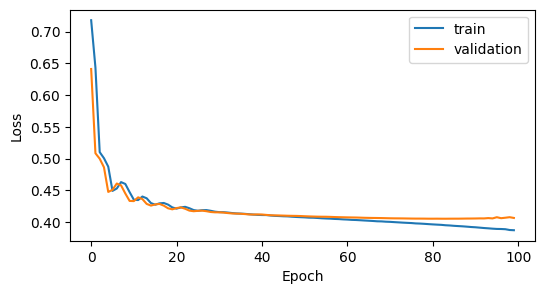

In [39]:
plt.figure(figsize=(6, 3))
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [40]:
# Compute ROC-AUC on the final model
model.eval()
with torch.no_grad():
    y_pred_test = model(X_w_test, X_d_test)
    y_pred_test_sigmoid = torch.sigmoid(y_pred_test).cpu().numpy()
    label_test_np = label_test.cpu().numpy()
    roc_auc = roc_auc_score(label_test_np, y_pred_test_sigmoid)
    print('Final Validation ROC-AUC:', roc_auc)

Final Validation ROC-AUC: 0.7319003407550235


## DeepFM

One imporatant difference between DeepFM and Wide&Deep is there is no need for expertise feature engineering (like manually create interactions between features) on the input. DeepFm will utilize the advantages of FM to capture pairwise relations.

In [70]:
df.dtypes

click                int64
C1                   int64
banner_pos           int64
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_model        object
device_type          int64
device_conn_type     int64
C14                  int64
C15                  int64
C16                  int64
C17                  int64
C18                  int64
C19                  int64
C20                  int64
C21                  int64
hr                  object
dtype: object

In [41]:
df_4 = df.copy()

In [ ]:
df_4.dtypes

In [ ]:
df_4.nunique()

In [73]:
# from sklearn.preprocessing import MinMaxScaler

In [89]:
df_4.nunique()

click                  2
C1                     7
banner_pos             7
site_id             2225
site_domain         2188
site_category         22
app_id              2241
app_domain           143
app_category          27
device_model        4380
device_type            4
device_conn_type       4
C14                 2088
C15                    8
C16                    9
C17                  411
C18                    4
C19                   65
C20                  161
C21                   60
hr                    24
dtype: int64

In [42]:
obj_features = list(df_4.select_dtypes(['object']).columns)
int_features = list(df_4.select_dtypes(['int64']).columns)
int_features.remove('click')

for feat in obj_features:
    lbe = LabelEncoder()
    df_4[feat] = lbe.fit_transform(df_4[feat])

In [44]:
from sklearn.preprocessing import MinMaxScaler

In [45]:
# Label Encoding for sparse features, and do simple Transformation for dense features
sparse_features = list(df_4.select_dtypes(['object']).columns)
dense_features = list(df_4.select_dtypes(['int64']).columns)
dense_features.remove('click')

target = ['click']

# for feat in sparse_features:
#     lbe = LabelEncoder()
#     df_4[feat] = lbe.fit_transform(df_4[feat])
mms = MinMaxScaler(feature_range=(0, 1))
df_4[dense_features] = mms.fit_transform(df_4[dense_features])

In [46]:
# count #unique features for each sparse field, and record dense feature field name
fixlen_feature_columns = [SparseFeat(feat, df_4[feat].nunique())
                          for feat in sparse_features] + [DenseFeat(feat, 1, )
                                                          for feat in dense_features]
# #print(fixlen_feature_columns)
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns



feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [70]:
# 3.generate input data for model

train, test = train_test_split(df_4, test_size=0.2, random_state=2022)
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}

#print(train_model_input[0,:])
# print(test[target].value_counts())

In [71]:
# 4.Define Model,train,predict and evaluate

device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

model = DeepFM(linear_feature_columns=linear_feature_columns, dnn_feature_columns=dnn_feature_columns,
                task='binary',
                l2_reg_embedding=1e-5, device=device)

model.compile("adagrad", "binary_crossentropy",
              metrics=["binary_crossentropy", "auc"], )

history = model.fit(train_model_input, train[target].values, epochs=1000, verbose=2,validation_split=0.2)
pred_ans = model.predict(test_model_input, batch_size=256)
print("")

cuda ready...
cuda:0
Train on 258745 samples, validate on 64687 samples, 1011 steps per epoch
Epoch 1/1000
7s - loss:  0.4426 - binary_crossentropy:  0.4426 - auc:  0.6181 - val_binary_crossentropy:  0.4390 - val_auc:  0.6196
Epoch 2/1000
8s - loss:  0.4393 - binary_crossentropy:  0.4392 - auc:  0.6256 - val_binary_crossentropy:  0.4385 - val_auc:  0.6222
Epoch 3/1000
7s - loss:  0.4387 - binary_crossentropy:  0.4387 - auc:  0.6276 - val_binary_crossentropy:  0.4383 - val_auc:  0.6235
Epoch 4/1000
7s - loss:  0.4385 - binary_crossentropy:  0.4385 - auc:  0.6287 - val_binary_crossentropy:  0.4384 - val_auc:  0.6245
Epoch 5/1000
7s - loss:  0.4384 - binary_crossentropy:  0.4384 - auc:  0.6290 - val_binary_crossentropy:  0.4380 - val_auc:  0.6246
Epoch 6/1000
7s - loss:  0.4382 - binary_crossentropy:  0.4382 - auc:  0.6294 - val_binary_crossentropy:  0.4381 - val_auc:  0.6251
Epoch 7/1000
7s - loss:  0.4382 - binary_crossentropy:  0.4382 - auc:  0.6296 - val_binary_crossentropy:  0.4379 -

In [72]:
from sklearn.metrics import log_loss

In [73]:
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

test LogLoss 0.4153
test AUC 0.7082


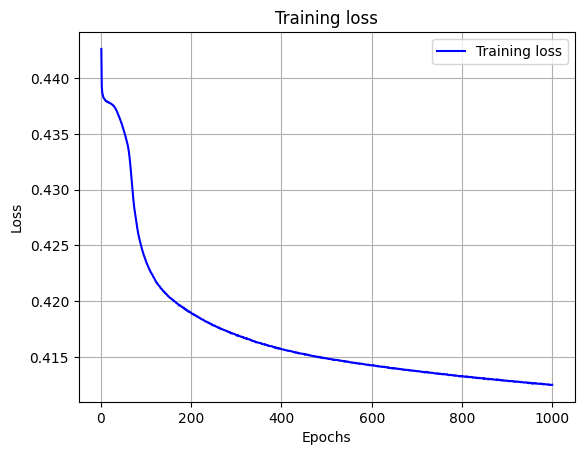

In [74]:
train_loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
